# CCF model calculation demo

The purpose of this notebook is to demonstrate the usage of the **`victor`** code for calculating the redshift-space cross-correlation between voids and galaxies or density-split-regions (DS) and galaxies. You need to have installed **`victor`** with:

`python -m pip install git+https://github.com/seshnadathur/victor.git@develop`

to run the examples given here.

In [1]:
# Start with basic module imports
import os
import numpy as np
import matplotlib.pyplot as plt
import yaml
from victor import CCFModel, plottools

%matplotlib inline
plt.style.use('seaborn-talk')

## 1. Getting started

Any model calculation requires first reading some input data from file, and specifying model choices. The example data used in this demo is taken from the file `example_void_model.hdf5` in the folder `data/example_data/` under the top-level directory. This path and the various default options we want to use here are specified in the YAML file `config/example_model_input.yaml`, so the first step is to read these in: 

In [2]:
top_level_dir = os.path.dirname(os.getcwd()) # to step back up from the current notebook directory

with open(os.path.join(top_level_dir, 'config/example_model_input.yaml')) as f:
    model = yaml.full_load(f)['model']

# see what model contains
model

{'input_model_data_file': 'data/example_data/example_void_model.hdf5',
 'rsd_model': 'streaming',
 'z_eff': 0.57,
 'cosmology': {'Omega_m': 0.31},
 'realspace_ccf': {'reconstruction': False,
  'format': 'multipoles',
  'ccf_keys': ['r', 'monopole']},
 'matter_ccf': {'model': 'template',
  'integrated': False,
  'template_keys': ['rdelta', 'delta'],
  'template_sigma8': 0.628,
  'bias': 1.9},
 'velocity_pdf': {'mean': {'model': 'linear'},
  'dispersion': {'model': 'template', 'template_keys': ['rsv', 'sigmav']}}}

[Note that `model` in the cell above is simply a Python dictionary. Instead of reading it from a YAML file we could also have just provided the same information via a dictionary created in this notebook.]

For a fuller description of the different options that can be provided in `model` and what they refer to, have a look at the inline comments in the YAML file at `config/boss_config.yaml`.

### 1.1. The input model data file

The most important information contained in `model` is the path to the input model data file (provided relative to the top level package directory). This file contains the input data necessary to compute the redshift-space void-galaxy or DS-galaxy CCF $\xi^s(\mathbf{s})$. The example data is arranged in HDF5 format, with arrays of different shapes identified by a series of keys. (The same information could also have been provided as a Python dictionary saved in `.npy` file format: `victor` can read either format so use whichever is more convenient and the code will deduce the format from the ending of the filename.) 

The input model data file **must** at a minimum contain information on the real-space CCF $\xi^r(\mathbf{r})$ since this is a necessary input to compute $\xi^s(\mathbf{s})$. The value of `model['realspace_ccf']['format']` above specifies that this realspace CCF information is provided in multipole format, and `model['realspace_ccf']['ccf_keys']` provide the keys to identify the arrays corresponding to values of $r$ and the monopole moment $\xi^r_0(r)$ in the file. [Extra keys could have been provided to identify quadrupole and hexadecapole moments of $\xi^r$ if desired, but we stick with the simple case for now.]

The input model data file **may** contain other optional information, depending on the use case. The most commonly used of these are:
* a template for the void-matter or DS-matter CCF $\delta(r)$ [necessary if `model['matter_ccf']['model']=='template'`, ignored otherwise]
    -  `model['matter_ccf']['template_keys']` provide the keys to identify the $r$ and $\delta(r)$ pairs in the file
    
    
* a template for the position-dependent standard deviation/RMS width $\sigma_v(r, \mu_r)$ of the (Gaussian) velocity PDF [always optional]
    - `model['velocity_pdf']['dispersion']['template_keys']` provide the keys to identify $r$, $\mu_r$ (optional, template can be spherically symmetric) and $\sigma_v(r, \mu_r)$ in the file
    
    
* **if** `model['realspace_ccf']['reconstruction']` is `True`, an array of the values of the reconstruction $\beta$ parameter used (identified by a key which should be specified in `model['realspace_ccf']['beta_key'])
    - if reconstruction has been used, the realspace CCF $\xi^r$ will also depend on $\beta$, so all multipoles provided will need to be 2D arrays with $\beta$ variation along the first dimension
    
Some additional things to note here:
1. If the void-matter or DS-matter template information in the file refers to the *enclosed* density contrast $\Delta(r)\equiv\frac{3}{r^3}\int_0^ry^2\delta(y)\,\mathrm{d}y$ rather than the matter CCF/density contrast in a shell $\delta(r)$, this can be specified by setting the value of `model['matter_ccf']['integrated']`.
2. If a matter template is used, information on the $\sigma_8$ value of the simulation used to calibrate this template **must** be provided, via the `template_sigma8` key. Note that this corresponds to $\sigma_8(z_\mathrm{sim})$ rather than at $\sigma_8(z=0)$!
3. The `bias` value here is somewhat arbitrary and is only ever used for some visualisation purposes, so don't worry too much about the exact value.

With this in mind, we can check the keys present in the `example_void_model.hdf5` file and confirm that they match the values we have specified in `model`:

In [3]:
import h5py

with h5py.File(os.path.join(top_level_dir, 'data/example_data/example_void_model.hdf5'), 'r') as f:
    print(list(f.keys()))

['delta', 'monopole', 'r', 'rdelta', 'rsv', 'sigmav']


### 1.2. The `CCFModel` class

We can now use the `model` dictionary to initialize an instance of the `CCFModel` class. Note that file paths in the YAML file were provided relative to the top level package directory; since we are running in the `notebooks/` subfolder here we can simply add a `dir` key to the dictonary to correct for this.

In [4]:
model['dir'] = top_level_dir
ccf = CCFModel(model)

### 1.3. The input data itself

Before starting any calculations, let's just visualise the input data we have provided:

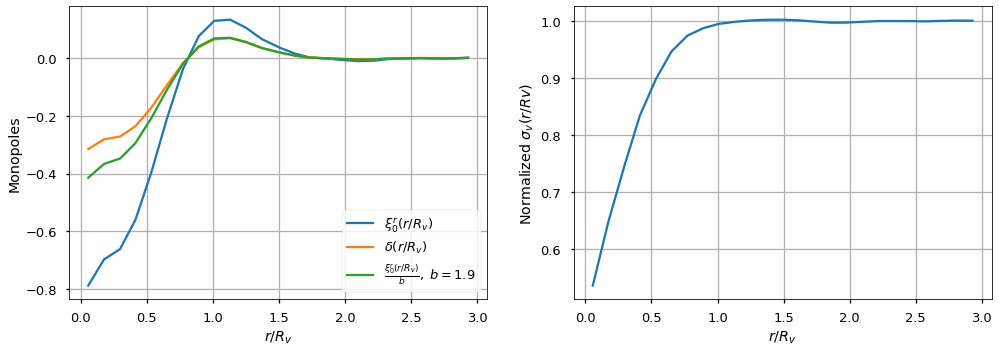

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ccf.plot_realspace_multipoles({'label': r'$\xi^r_0(r/R_v)$'}, ell=0, ax=ax1, **{'xlabel': r'$r/R_v$', 'ylabel': r'Monopoles'})
params = {} # empty dict used to satisfy the call signature
# get the default template matter ccf profile
delta, integ_delta = ccf.delta_profiles(ccf.r, params)
# override the default set during initialisation through kwargs and calculate matter ccf using linear bias approximation
bias_delta, bias_integ_delta = ccf.delta_profiles(ccf.r, params, **{'matter_model': 'linear_bias'}) 
ax1.plot(ccf.r, delta, label=r'$\delta(r/R_v)$')
ax1.plot(ccf.r, bias_delta, label=rf'$\frac{{\xi^r_0(r/R_v)}}{{b}},\;b={model["matter_ccf"]["bias"]}$')
ax1.legend(loc='lower right')
ax1.grid()

from scipy.interpolate import RectBivariateSpline
# internally, victor always holds sigma_v(r, mu) even though in this example mu information is redundant 
sv_spl = RectBivariateSpline(ccf.r_for_sv, ccf.mu_for_sv, ccf.sv_rmu.T)
ax2.plot(ccf.r, sv_spl.ev(ccf.r, 0)) # choose any value 0<=mu<=1
ax2.grid()
ax2.set_xlabel(r'$r/R_v$')
ax2.set_ylabel(r'Normalized $\sigma_v(r/Rv)$')
plt.tight_layout(w_pad=3)

The real-space CCF monopole $\xi^r_0$ data here has been chosen to match that shown in Figure 4 of [this paper](https://arxiv.org/abs/2007.07895) (green dotted line). All radial distances are therefore expressed in units of the void radius $R_v$ as well to match that paper (but – with one exception explained below – this doesn't affect any of the calculations performed).

The 'template' matter ccf profile $\delta(r/R_v)$ is fake/arbitrary, for demonstration purposes chosen to be similar to but not the same as what would be expected from applying a constant linear bias to the real-space CCF, $\xi^r_0/b$. The shape of the $\sigma_v(r/R_v)$ profile is also quite generic for demonstration purposes.

## 2. Basic Usage

The primary functionality of the `CCFModel` class is to allow computation of the multipoles of the redshift-space CCF at any given point in parameter space:

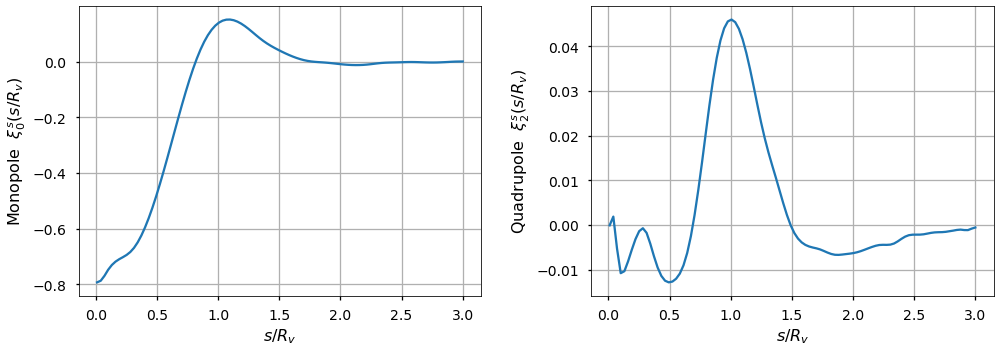

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
# full set of parameters applicable here is (fsigma8, sigma_v, epsilon=aperp/apar)
# NOTE: a sensible value for the normalization sigma_v would normally be ~350-400 km/s BUT because in this example distances are expressed in units of 
# r/R_v in fact we need to now provide sigma_v/R_v instead (in units of km/s/(Mpc/h)): for typical void sizes of ~50 Mpc/h this gives the number below
params = {'fsigma8': 0.47, 'sigma_v': 7, 'epsilon': 1.0}
s = np.linspace(0.01, 3, 100)
th = ccf.theory_multipoles(s, params, poles=[0, 2])
ax1.plot(s, th['0'])
ax2.plot(s, th['2'])
for ax in [ax1, ax2]: 
    ax.set_xlabel(r'$s/R_v$', fontsize=16)
    ax.tick_params(labelsize=14)
    ax.grid()
ax1.set_ylabel(r'Monopole  $\xi^s_0(s/R_v)$', fontsize=16)
ax2.set_ylabel(r'Quadrupole  $\xi^s_2(s/R_v)$', fontsize=16)
plt.tight_layout(w_pad=3)

The default model evaluation options set during the initialization can also be overridden via kwargs provided in the function call (see the fuller discussion of the meanings of the different options below): 

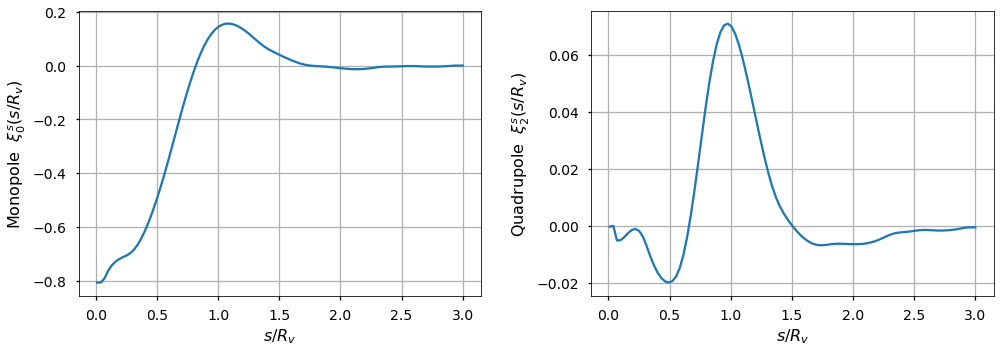

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
params = {'beta': 0.4, 'epsilon': 1.0}
s = np.linspace(0.01, 3, 100)
th = ccf.theory_multipoles(s, params, poles=[0, 2], **{'rsd_model': 'kaiser', 'matter_model': 'linear_bias'})
ax1.plot(s, th['0'])
ax2.plot(s, th['2'])
for ax in [ax1, ax2]: 
    ax.set_xlabel(r'$s/R_v$', fontsize=16)
    ax.tick_params(labelsize=14)
    ax.grid()
ax1.set_ylabel(r'Monopole  $\xi^s_0(s/R_v)$', fontsize=16)
ax2.set_ylabel(r'Quadrupole  $\xi^s_2(s/R_v)$', fontsize=16)
plt.tight_layout(w_pad=3)

For plotting purposes it can be more convenient to use the `plot_model_multipoles` class method instead, especially when comparing different points in parameter space:

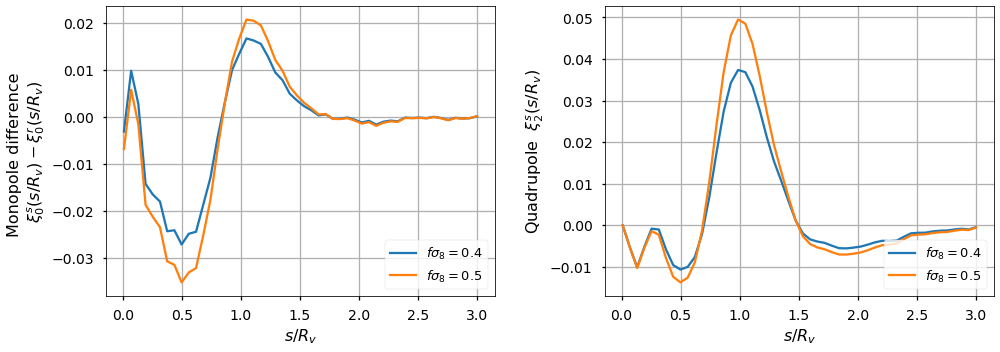

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
params1 = {'fsigma8': 0.4, 'sigma_v': 7, 'epsilon': 1.0, 'label': r'$f\sigma_8=0.4$'}
params2 = {'fsigma8': 0.5, 'sigma_v': 7, 'epsilon': 1.0, 'label': r'$f\sigma_8=0.5$'}
s = np.linspace(0.01, 3)
ccf.plot_model_multipoles(params1, params2, s=s, ax=ax1, ell=0, diff=True, **{'xlabel': r'$s/R_v$', 'ylabel': 'Monopole difference \n' + r'$\xi^s_0(s/R_v)-\xi^r_0(s/R_v)$'})
ccf.plot_model_multipoles(params1, params2, s=s, ax=ax2, ell=2, **{'xlabel': r'$s/R_v$', 'ylabel': r'Quadrupole  $\xi^s_2(s/R_v)$'})
ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
for ax in [ax1, ax2]:
    ax.xaxis.get_label().set_fontsize(16)
    ax.yaxis.get_label().set_fontsize(16)
    ax.tick_params(labelsize=14)
    ax.grid()
plt.tight_layout(w_pad=3)

We can also compute and plot the 2D CCF $\xi^s(s_\perp,s_{||})$ instead:

[-2. -1.  0.  1.  2.]


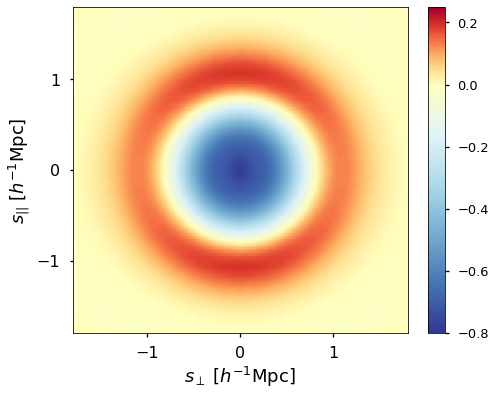

In [20]:
params = {'fsigma8': 0.47, 'sigma_v': 7, 'epsilon': 1.0}
xi2d = ccf.theory_xi_2D(params, rmax=2.5)
s = np.linspace(0, 1.8)
plottools.plot_2D_ccf(xi2d, s, vmin=-0.8, vmax=0.25, axis_label='s')